In [3]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm


esg_csv = "/workspaces/ginappedrosa_project_test/sp500_esg_ceo_info-filtered.csv"  
esg_df = pd.read_csv(esg_csv)

print("Columnas CSV ESG:", esg_df.columns)
print("Número de tickers en CSV:", esg_df["Ticker"].nunique())

Columnas CSV ESG: Index(['Ticker', 'ESG Score', 'Governance Score', 'Environment Score',
       'Social Score', 'ESG Score Date', 'ESG Status', 'CEO Full Name',
       'CEO Gender', 'CEO Status', 'Year'],
      dtype='object')
Número de tickers en CSV: 426


In [4]:
# Selección de únicamente 50 tickers del CSV sp500_esg_ceo_info-filtered

tickers = esg_df["Ticker"].dropna().unique().tolist()[:50]

start_date = "2018-01-01"
end_date = "2025-08-30"

all_data = []


In [5]:
batch_size = 50
for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i+batch_size]
    print(f"\nDescargando batch {i//batch_size + 1} de {len(tickers)//batch_size + 1}...")
    
    try:
        df = yf.download(
            batch,
            start=start_date,
            end=end_date,
            progress=False,
            auto_adjust=False  # 
        )
        
        # Pasamos de columnas multi-índice a columnas simples
        df = df.stack(level=1).reset_index()
        df.rename(columns={"level_1": "Ticker"}, inplace=True)
        
        all_data.append(df)
    except Exception as e:
        print(f"Error en batch {i//batch_size + 1}: {e}")



Descargando batch 1 de 2...


/tmp/ipykernel_26959/1142295356.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level=1).reset_index()


In [6]:
# Unimos todos los datos financieros
fin_df = pd.concat(all_data, ignore_index=True)

print(f"\nDatos financieros: {fin_df.shape}")


Datos financieros: (96269, 8)


In [7]:
# Unimos con ESG (por ticker)
dataset_final = pd.merge(fin_df, esg_df, on="Ticker", how="inner")

In [8]:
# Creamos features de volatilidad para obtener 2 posibles targets (y) para nuestro futuro modelo predictivo

dataset_final["Daily_Return"] = dataset_final.groupby("Ticker")["Adj Close"].pct_change()
dataset_final["Daily_Volatility"] = (
    dataset_final.groupby("Ticker")["Daily_Return"]
    .rolling(5)
    .std()
    .reset_index(0, drop=True)
)

In [9]:
# Guardar CSV final
dataset_final.to_csv("dataset_final.csv", index=False)

print(f"\nDataset guardado como 'dataset_final.csv'")
print("Shape final:", dataset_final.shape)
print("\nPrimeras filas:\n", dataset_final.head())

dataset_final.info()


Dataset guardado como 'dataset_final.csv'
Shape final: (96269, 20)

Primeras filas:
         Date Ticker  Adj Close      Close       High        Low       Open  \
0 2018-01-02      A  63.909576  67.599998  67.889999  67.339996  67.419998   
1 2018-01-02    AAL  51.647564  52.990002  53.099998  51.900002  52.330002   
2 2018-01-02   AAPL  40.380985  43.064999  43.075001  42.314999  42.540001   
3 2018-01-02   ABBV  70.405556  98.410004  98.900002  96.750000  97.139999   
4 2018-01-02    ABT  51.307533  58.790001  59.200001  57.820000  58.200001   

        Volume  ESG Score  Governance Score  Environment Score  Social Score  \
0    1047800.0      15.24              6.26               0.34          8.65   
1    4084700.0      29.10              5.26              11.53         12.31   
2  102223600.0      16.68              9.18               0.65          6.86   
3    4561300.0      27.84              9.95               1.12         16.77   
4   10112800.0      24.98              8.36  

EDA

In [10]:
dataset_final.head()

Date Ticker  Adj Close      Close       High        Low       Open  \
0 2018-01-02      A  63.909576  67.599998  67.889999  67.339996  67.419998   
1 2018-01-02    AAL  51.647564  52.990002  53.099998  51.900002  52.330002   
2 2018-01-02   AAPL  40.380985  43.064999  43.075001  42.314999  42.540001   
3 2018-01-02   ABBV  70.405556  98.410004  98.900002  96.750000  97.139999   
4 2018-01-02    ABT  51.307533  58.790001  59.200001  57.820000  58.200001   

        Volume  ESG Score  Governance Score  Environment Score  Social Score  \
0    1047800.0      15.24              6.26               0.34          8.65   
1    4084700.0      29.10              5.26              11.53         12.31   
2  102223600.0      16.68              9.18               0.65          6.86   
3    4561300.0      27.84              9.95               1.12         16.77   
4   10112800.0      24.98              8.36               3.03         13.59   

  ESG Score Date ESG Status            CEO Full Name CEO Gender CEO Status  \
0     01/01/2023    success  Mr. Michael R. McMullen       male    success   
1     01/01/2023    success   Mr. Robert D. Isom Jr.       male    success   
2     01/08/2022    success      Mr. Timothy D. Cook       male    success   
3     01/08/2022    success  Mr. Richard A. Gonzalez       male    success   
4     01/08/2022    success       Mr. Robert B. Ford       male    success   

   Year  Daily_Return  Daily_Volatility  
0    23           NaN               NaN  
1    23           NaN               NaN  
2    22           NaN               NaN  
3    22           NaN               NaN  
4    22           NaN               NaN

In [11]:
dataset_final.shape

(96269, 20)

In [12]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96269 entries, 0 to 96268
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               96269 non-null  datetime64[ns]
 1   Ticker             96269 non-null  object        
 2   Adj Close          96269 non-null  float64       
 3   Close              96269 non-null  float64       
 4   High               96269 non-null  float64       
 5   Low                96269 non-null  float64       
 6   Open               96269 non-null  float64       
 7   Volume             96269 non-null  float64       
 8   ESG Score          96269 non-null  float64       
 9   Governance Score   96269 non-null  float64       
 10  Environment Score  96269 non-null  float64       
 11  Social Score       96269 non-null  float64       
 12  ESG Score Date     96269 non-null  object        
 13  ESG Status         96269 non-null  object        
 14  CEO Fu

In [13]:
dataset_final.drop_duplicates()

Date Ticker   Adj Close       Close        High         Low  \
0     2018-01-02      A   63.909576   67.599998   67.889999   67.339996   
1     2018-01-02    AAL   51.647564   52.990002   53.099998   51.900002   
2     2018-01-02   AAPL   40.380985   43.064999   43.075001   42.314999   
3     2018-01-02   ABBV   70.405556   98.410004   98.900002   96.750000   
4     2018-01-02    ABT   51.307533   58.790001   59.200001   57.820000   
...          ...    ...         ...         ...         ...         ...   
96264 2025-08-29  GOOGL  212.719742  212.910004  214.649994  210.199997   
96265 2025-08-29    LNT   65.070000   65.070000   65.459999   64.750000   
96266 2025-08-29    MMM  155.529999  155.529999  158.240005  155.320007   
96267 2025-08-29     MO   67.209999   67.209999   67.250000   66.459999   
96268 2025-08-29      T   29.290001   29.290001   29.330000   28.950001   

             Open       Volume  ESG Score  Governance Score  \
0       67.419998    1047800.0      15.24              6.26   
1       52.330002    4084700.0      29.10              5.26   
2       42.540001  102223600.0      16.68              9.18   
3       97.139999    4561300.0      27.84              9.95   
4       58.200001   10112800.0      24.98              8.36   
...           ...          ...        ...               ...   
96264  210.509995   39728400.0      24.14             11.39   
96265   65.099998    1669600.0      21.87              6.18   
96266  157.600006    3279100.0      33.61              7.72   
96267   66.550003    5930600.0      23.99              6.35   
96268   29.020000   26562400.0      22.07              6.66   

       Environment Score  Social Score ESG Score Date ESG Status  \
0                   0.34          8.65     01/01/2023    success   
1                  11.53         12.31     01/01/2023    success   
2                   0.65          6.86     01/08/2022    success   
3                   1.12         16.77     01/08/2022    success   
4                   3.03         13.59     01/08/2022    success   
...                  ...           ...            ...        ...   
96264               1.66         11.10     01/08/2022    success   
96265              10.04          5.65     01/01/2023    success   
96266              12.33         13.56     01/08/2022    success   
96267               4.66         12.98     01/08/2022    success   
96268               2.27         13.15     01/08/2022    success   

                    CEO Full Name CEO Gender CEO Status  Year  Daily_Return  \
0         Mr. Michael R. McMullen       male    success    23           NaN   
1          Mr. Robert D. Isom Jr.       male    success    23           NaN   
2             Mr. Timothy D. Cook       male    success    22           NaN   
3         Mr. Richard A. Gonzalez       male    success    22           NaN   
4              Mr. Robert B. Ford       male    success    22           NaN   
...                           ...        ...        ...   ...           ...   
96264          Mr. Sundar  Pichai       male    success    22      0.006001   
96265          Mr. John O. Larsen       male    success    23      0.000769   
96266        Mr. Michael F. Roman       male    success    22     -0.012884   
96267  Mr. William F. Gifford Jr.       male    success    22      0.011894   
96268         Mr. John T. Stankey       male    success    22      0.012094   

       Daily_Volatility  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
96264          0.010028  
96265          0.006497  
96266          0.009568  
96267          0.008617  
96268          0.010537  

[96269 rows x 20 columns]

In [14]:
dataset_final.dropna(inplace=True)

In [15]:
dataset_final.shape

(96019, 20)

In [16]:
tickers_only = dataset_final[['Ticker']].drop_duplicates()  # eliminamos duplicados de los tickers para obtener los nombres exactos de las empresas elegidas

tickers_only.to_csv("tickers_only.csv", index=False)

In [17]:
dataset_final.drop(["CEO Full Name", "CEO Status"], axis = 1, inplace = True)
dataset_final.head()

Date Ticker  Adj Close       Close        High        Low  \
250 2018-01-09      A  67.851906   71.769997   72.330002  70.169998   
251 2018-01-09    AAL  50.760609   52.080002   53.369999  52.009998   
252 2018-01-09   AAPL  40.866245   43.582500   43.764999  43.352501   
253 2018-01-09   ABBV  71.714790  100.239998  100.660004  98.699997   
254 2018-01-09    ABT  51.420975   58.919998   59.099998  58.380001   

          Open      Volume  ESG Score  Governance Score  Environment Score  \
250  70.680000   2666100.0      15.24              6.26               0.34   
251  52.970001   3426000.0      29.10              5.26              11.53   
252  43.637501  86336000.0      16.68              9.18               0.65   
253  99.489998   4055400.0      27.84              9.95               1.12   
254  59.099998   7466900.0      24.98              8.36               3.03   

     Social Score ESG Score Date ESG Status CEO Gender  Year  Daily_Return  \
250          8.65     01/01/2023    success       male    23      0.024553   
251         12.31     01/01/2023    success       male    23     -0.000959   
252          6.86     01/08/2022    success       male    22     -0.000115   
253         16.77     01/08/2022    success       male    22      0.007539   
254         13.59     01/08/2022    success       male    22      0.001700   

     Daily_Volatility  
250          0.014419  
251          0.007580  
252          0.005833  
253          0.014342  
254          0.002566

In [18]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96019 entries, 250 to 96268
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               96019 non-null  datetime64[ns]
 1   Ticker             96019 non-null  object        
 2   Adj Close          96019 non-null  float64       
 3   Close              96019 non-null  float64       
 4   High               96019 non-null  float64       
 5   Low                96019 non-null  float64       
 6   Open               96019 non-null  float64       
 7   Volume             96019 non-null  float64       
 8   ESG Score          96019 non-null  float64       
 9   Governance Score   96019 non-null  float64       
 10  Environment Score  96019 non-null  float64       
 11  Social Score       96019 non-null  float64       
 12  ESG Score Date     96019 non-null  object        
 13  ESG Status         96019 non-null  object        
 14  CEO Gende

## ANÁLISIS DE VARIABLES UNIVARIANTE ##

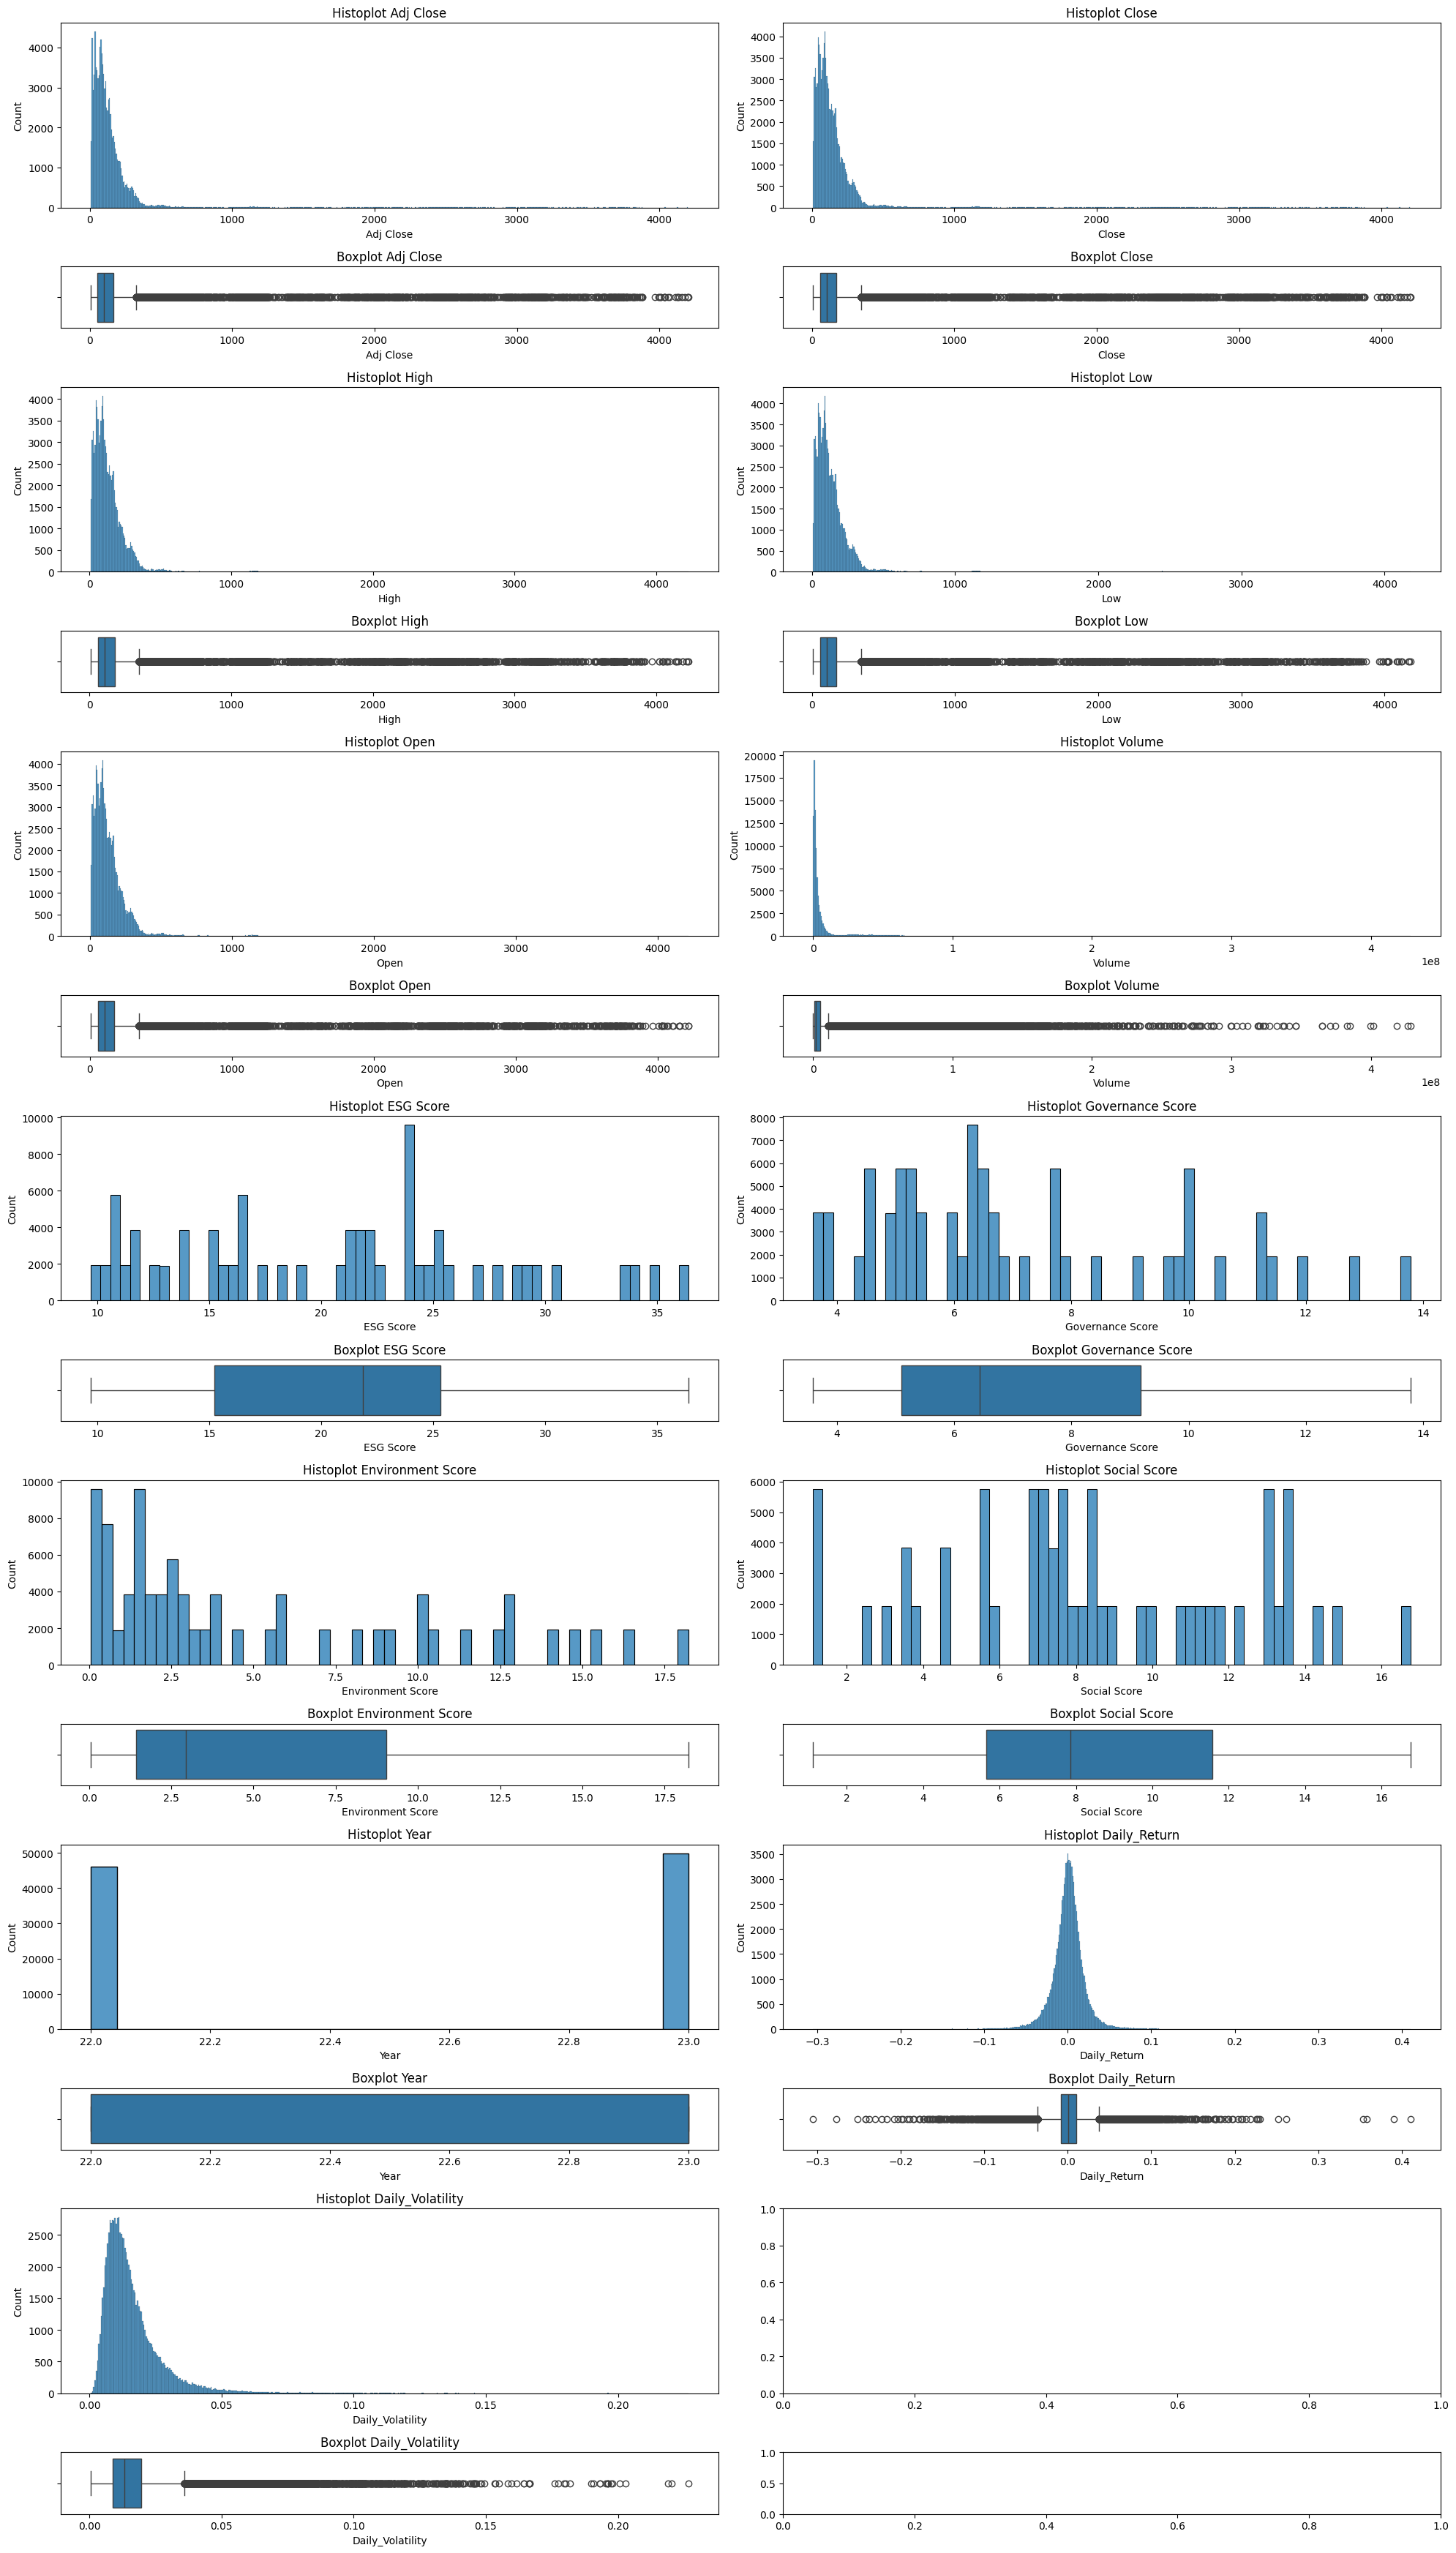

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns

numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)

# Number of rows: 2 per variable(histoplot + boxplot), 2 columns per row
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)
total_rows = nrows * 2  # double per variable.

fig, axes = plt.subplots(
    nrows=total_rows,
    ncols=ncols,
    figsize=(20, total_rows * 2.5),
    gridspec_kw={"height_ratios": [6, 2] * nrows}
)

axes = axes.reshape(total_rows, ncols)

# Automatic plot
for i, var in enumerate(numerical_variables):
    row = (i // ncols) * 2
    col = i % ncols

    # Histoplot
    sns.histplot(data=dataset_final, x=var, ax=axes[row, col])
    axes[row, col].set_title(f"Histoplot {var}")

    # Boxplot
    sns.boxplot(data=dataset_final, x=var, ax=axes[row + 1, col])
    axes[row + 1, col].set_title(f"Boxplot {var}")


plt.tight_layout()
plt.show()


In [20]:
# CATEGÓRICAS

categorical_variables = dataset_final.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Variables:", categorical_variables)

Categorical Variables: ['Ticker', 'ESG Score Date', 'ESG Status', 'CEO Gender']


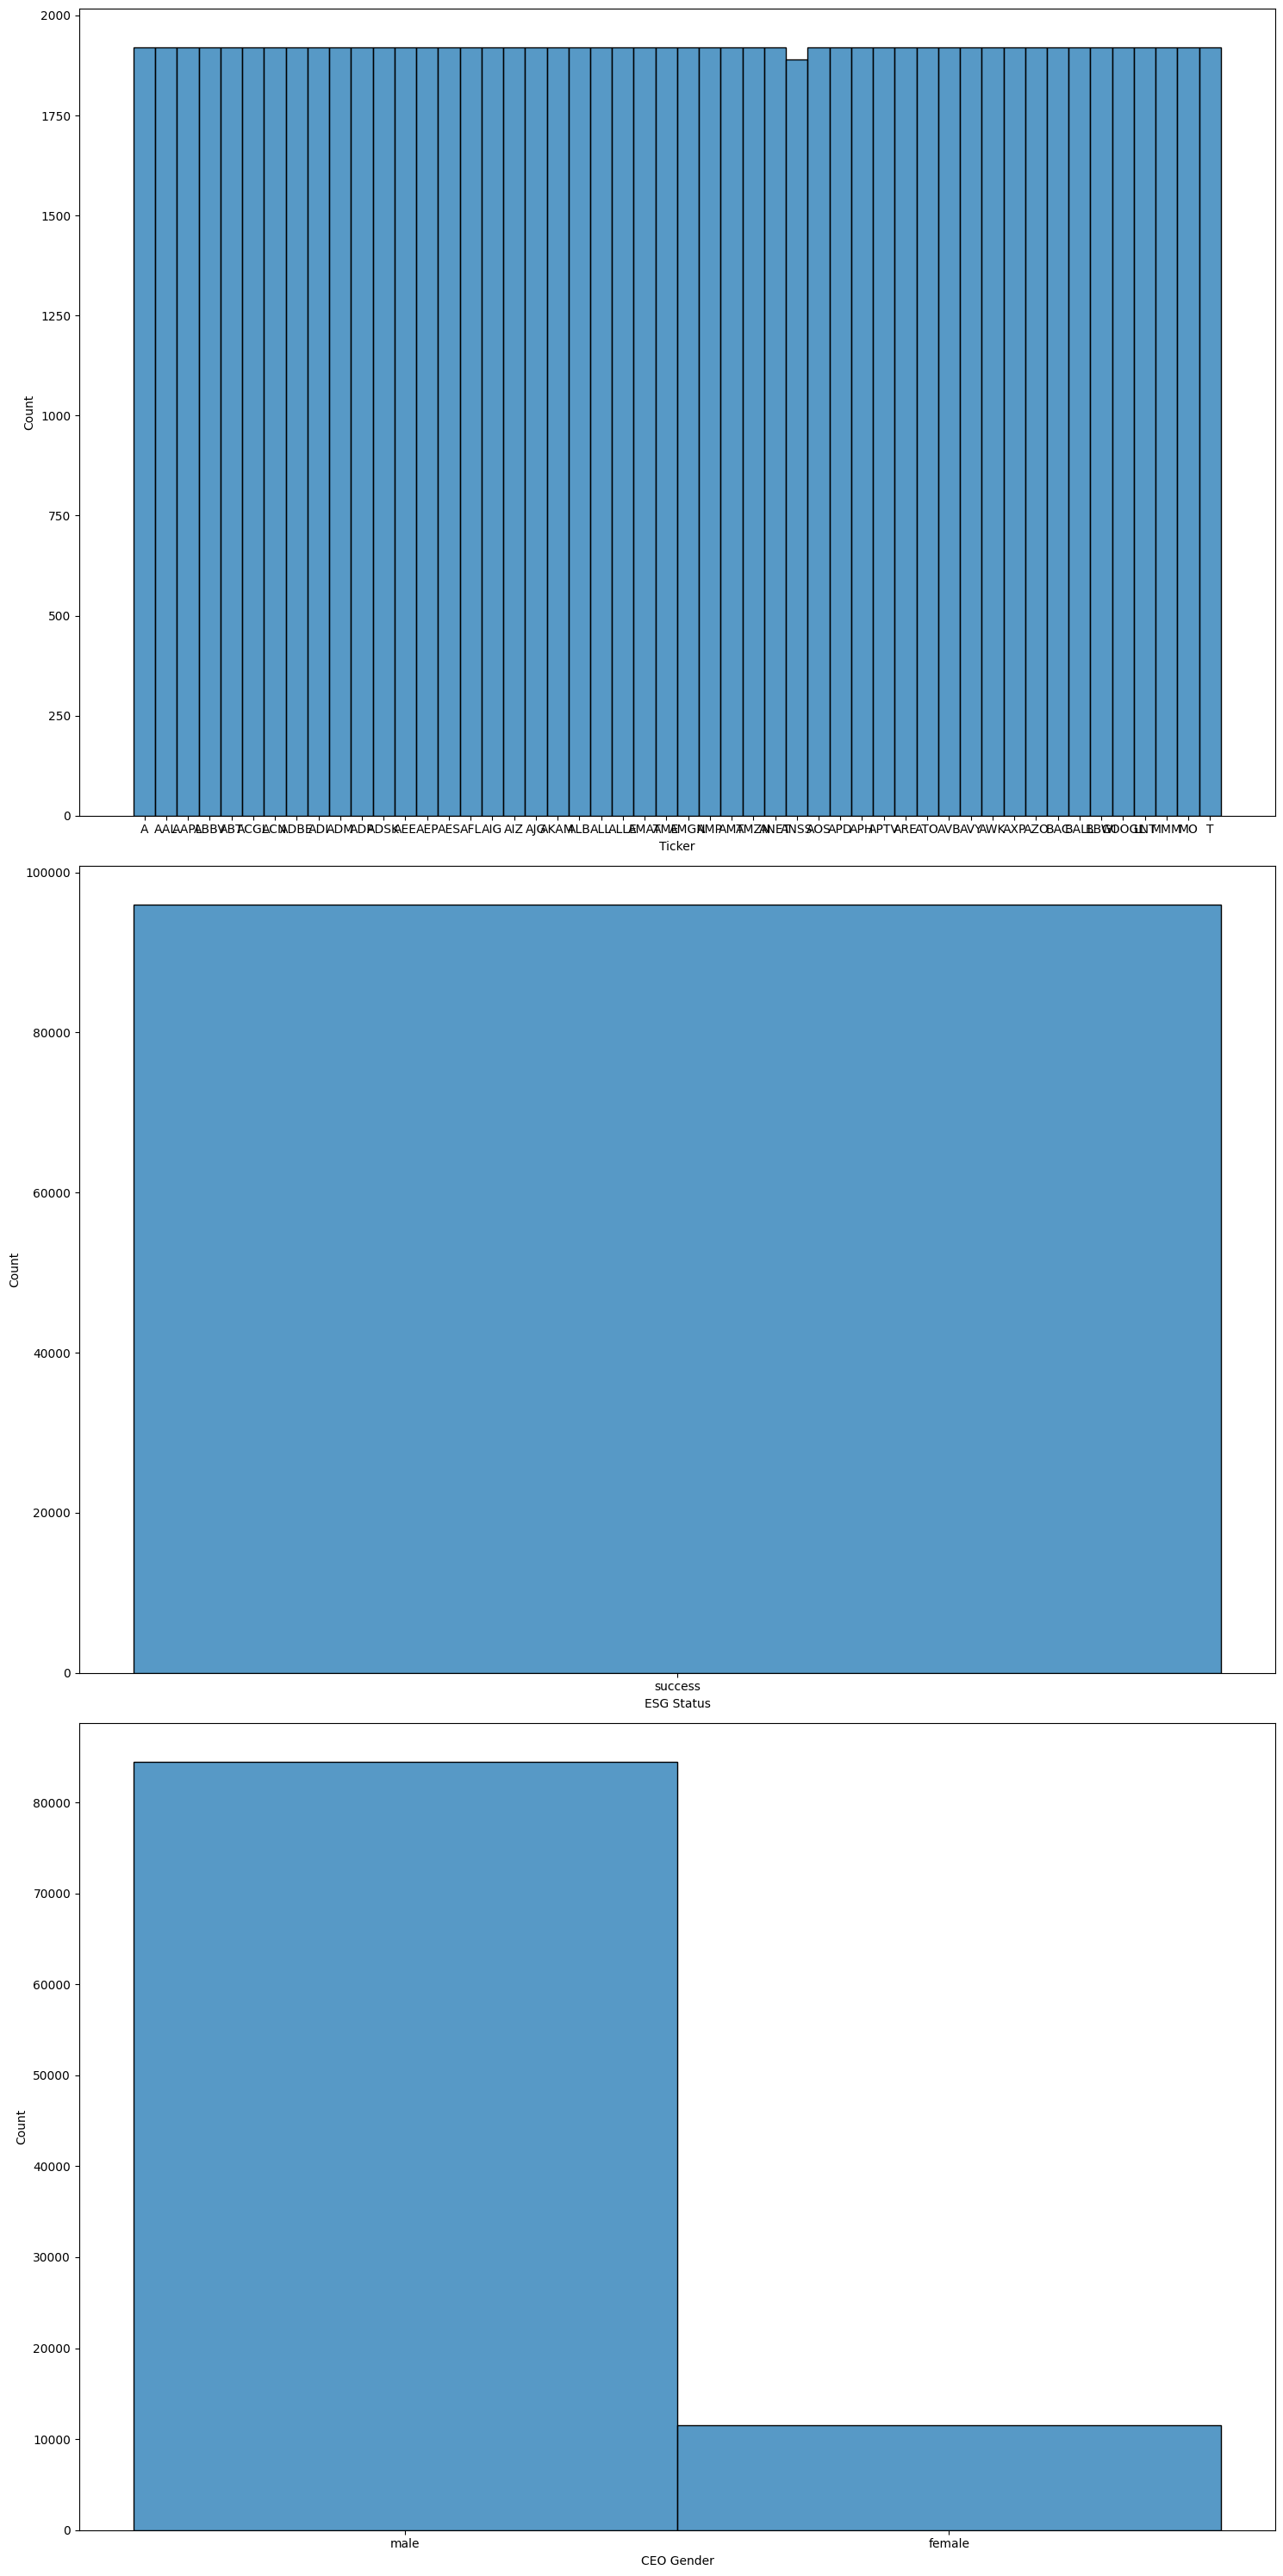

In [21]:

fig, axis = plt.subplots(3, figsize=(15, 30))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = dataset_final, x = "Ticker") 
sns.histplot(ax = axis[1], data = dataset_final, x = "ESG Status")
sns.histplot(ax = axis[2], data = dataset_final, x = "CEO Gender")

plt.tight_layout()
plt.show()

In [22]:
#MULTIVARIANTE: numérico-numérico

numerical_variables

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score',
       'Governance Score', 'Environment Score', 'Social Score', 'Year',
       'Daily_Return', 'Daily_Volatility'],
      dtype='object')

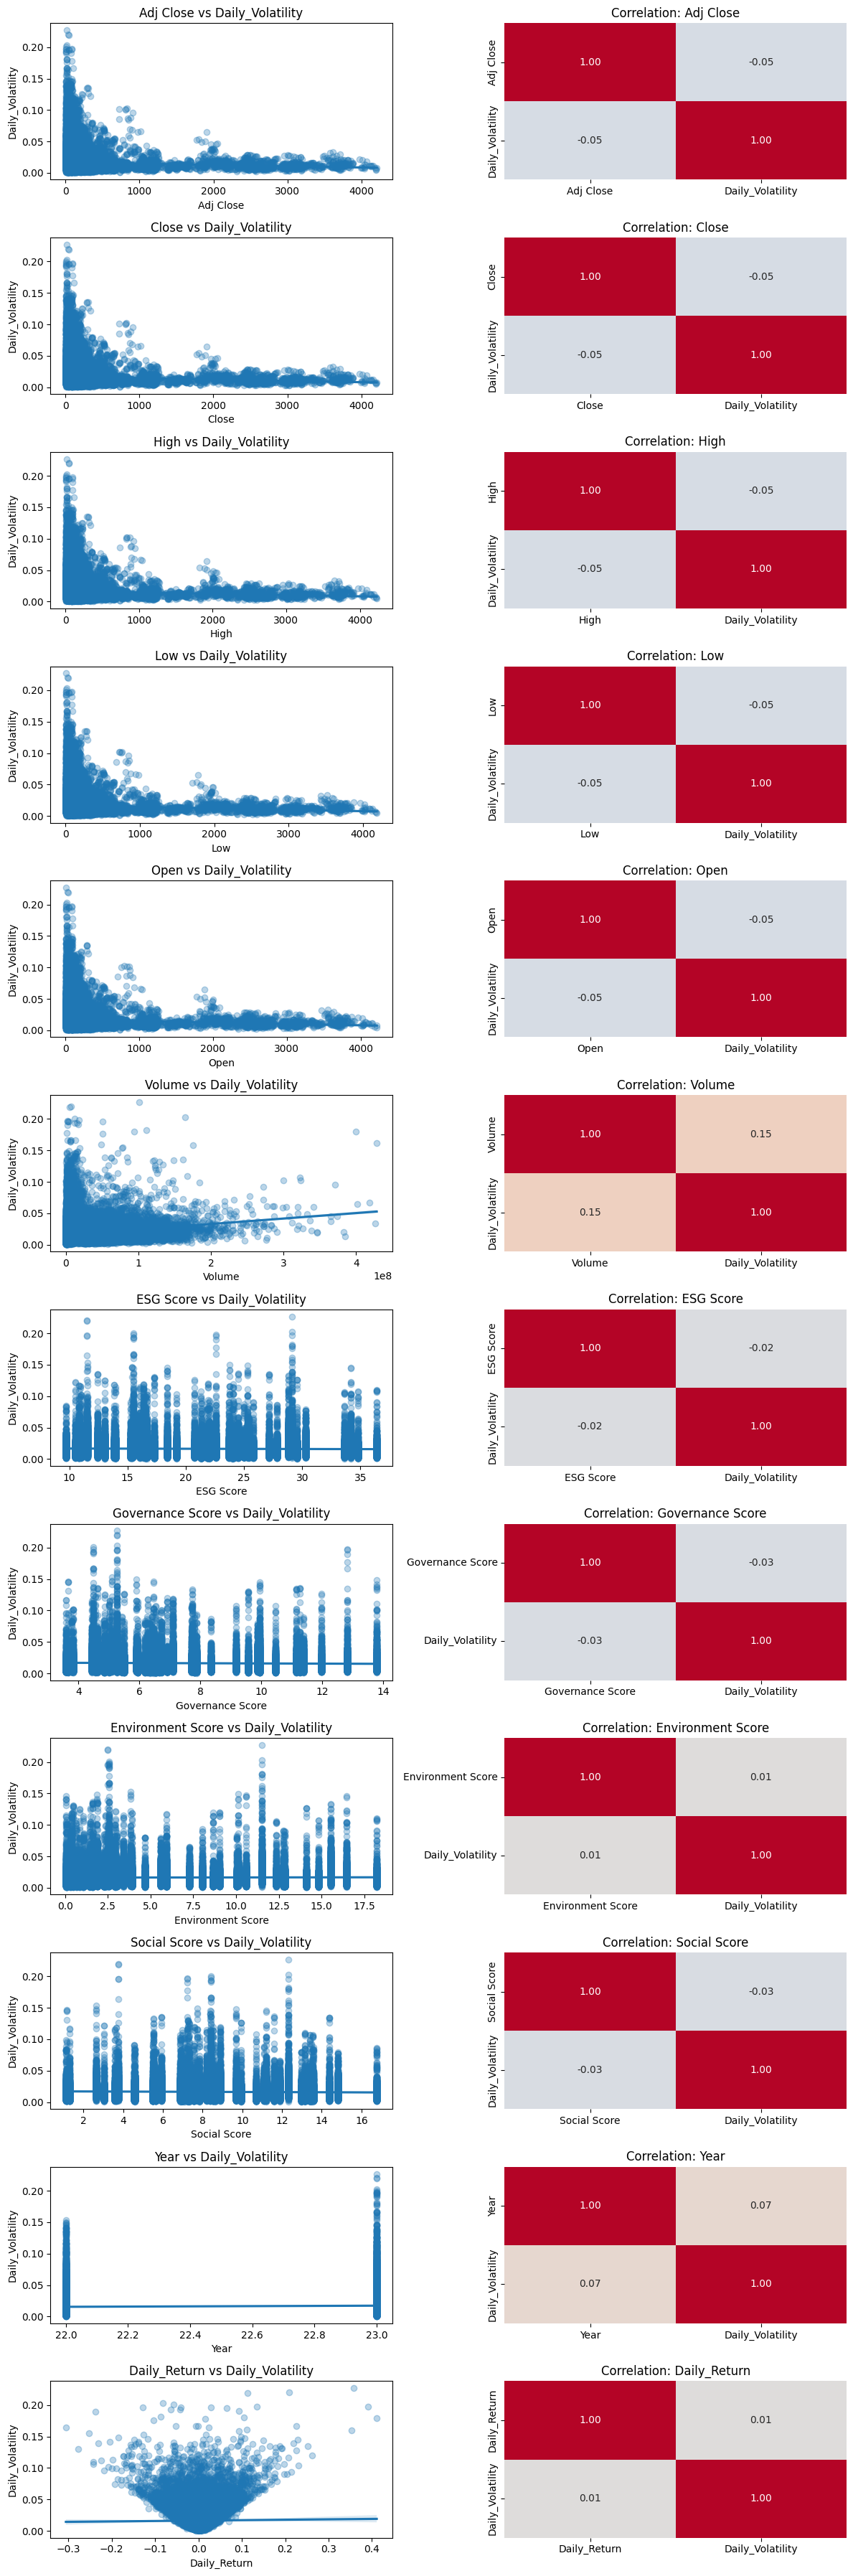

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables que quieres comparar con Daily_Volatility
variables = [
    "Adj Close", "Close", "High", "Low", "Open", "Volume",
    "ESG Score", "Governance Score", "Environment Score",
    "Social Score", "Year", "Daily_Return"
]

n_vars = len(variables)
ncols = 2   # un regplot y un heatmap por fila
nrows = n_vars  # una fila por variable

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(12, nrows * 3)
)

# Si solo hay 1 fila, convertir axes a 2D para que no dé error
if nrows == 1:
    axes = [axes]

for i, var in enumerate(variables):
    # Regplot a la izquierda
    sns.regplot(
        ax=axes[i, 0], 
        data=dataset_final, 
        x=var, 
        y="Daily_Volatility", 
        scatter_kws={"alpha": 0.3}
    )
    axes[i, 0].set_title(f"{var} vs Daily_Volatility")

    # Heatmap a la derecha
    corr = dataset_final[[var, "Daily_Volatility"]].corr()
    sns.heatmap(
        corr, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i, 1], 
        cbar=False, 
        cmap="coolwarm",
        vmin=-1, vmax=1
    )
    axes[i, 1].set_title(f"Correlation: {var}")

plt.tight_layout()
plt.show()


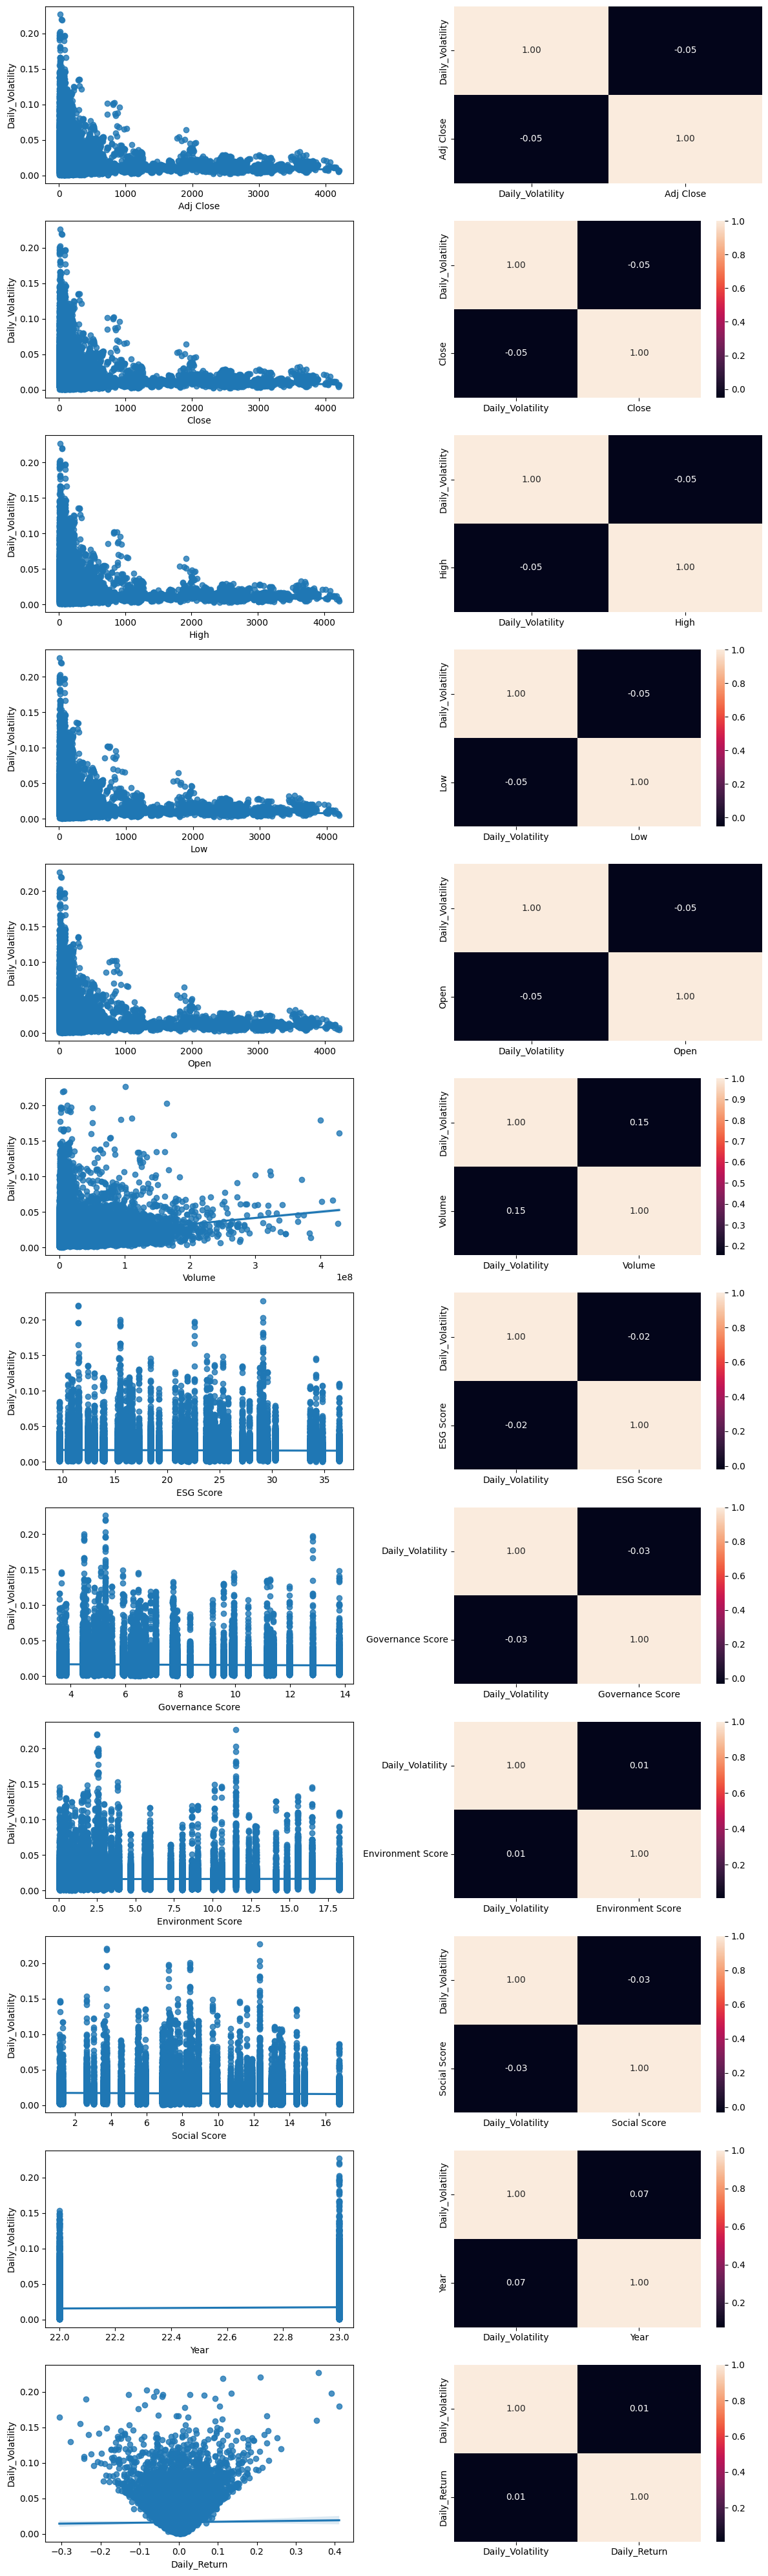

In [24]:
fig, axis = plt.subplots(12, 2, figsize=(12, 40))  # 12 variables → 12 filas x 2 columnas

sns.regplot(ax=axis[0, 0], data=dataset_final, x="Adj Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Adj Close"]].corr(), annot=True, fmt=".2f", ax=axis[0, 1], cbar=False)

sns.regplot(ax=axis[1, 0], data=dataset_final, x="Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Close"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

sns.regplot(ax=axis[2, 0], data=dataset_final, x="High", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "High"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1], cbar=False)

sns.regplot(ax=axis[3, 0], data=dataset_final, x="Low", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Low"]].corr(), annot=True, fmt=".2f", ax=axis[3, 1])

sns.regplot(ax=axis[4, 0], data=dataset_final, x="Open", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Open"]].corr(), annot=True, fmt=".2f", ax=axis[4, 1], cbar=False)

sns.regplot(ax=axis[5, 0], data=dataset_final, x="Volume", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Volume"]].corr(), annot=True, fmt=".2f", ax=axis[5, 1])

sns.regplot(ax=axis[6, 0], data=dataset_final, x="ESG Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "ESG Score"]].corr(), annot=True, fmt=".2f", ax=axis[6, 1])

sns.regplot(ax=axis[7, 0], data=dataset_final, x="Governance Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Governance Score"]].corr(), annot=True, fmt=".2f", ax=axis[7, 1])

sns.regplot(ax=axis[8, 0], data=dataset_final, x="Environment Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Environment Score"]].corr(), annot=True, fmt=".2f", ax=axis[8, 1])

sns.regplot(ax=axis[9, 0], data=dataset_final, x="Social Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Social Score"]].corr(), annot=True, fmt=".2f", ax=axis[9, 1])

sns.regplot(ax=axis[10, 0], data=dataset_final, x="Year", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Year"]].corr(), annot=True, fmt=".2f", ax=axis[10, 1])

sns.regplot(ax=axis[11, 0], data=dataset_final, x="Daily_Return", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Daily_Return"]].corr(), annot=True, fmt=".2f", ax=axis[11, 1])

plt.tight_layout()
plt.show()


MULTIVARIANTE CATEGÓRICO-CATEGÓRICO

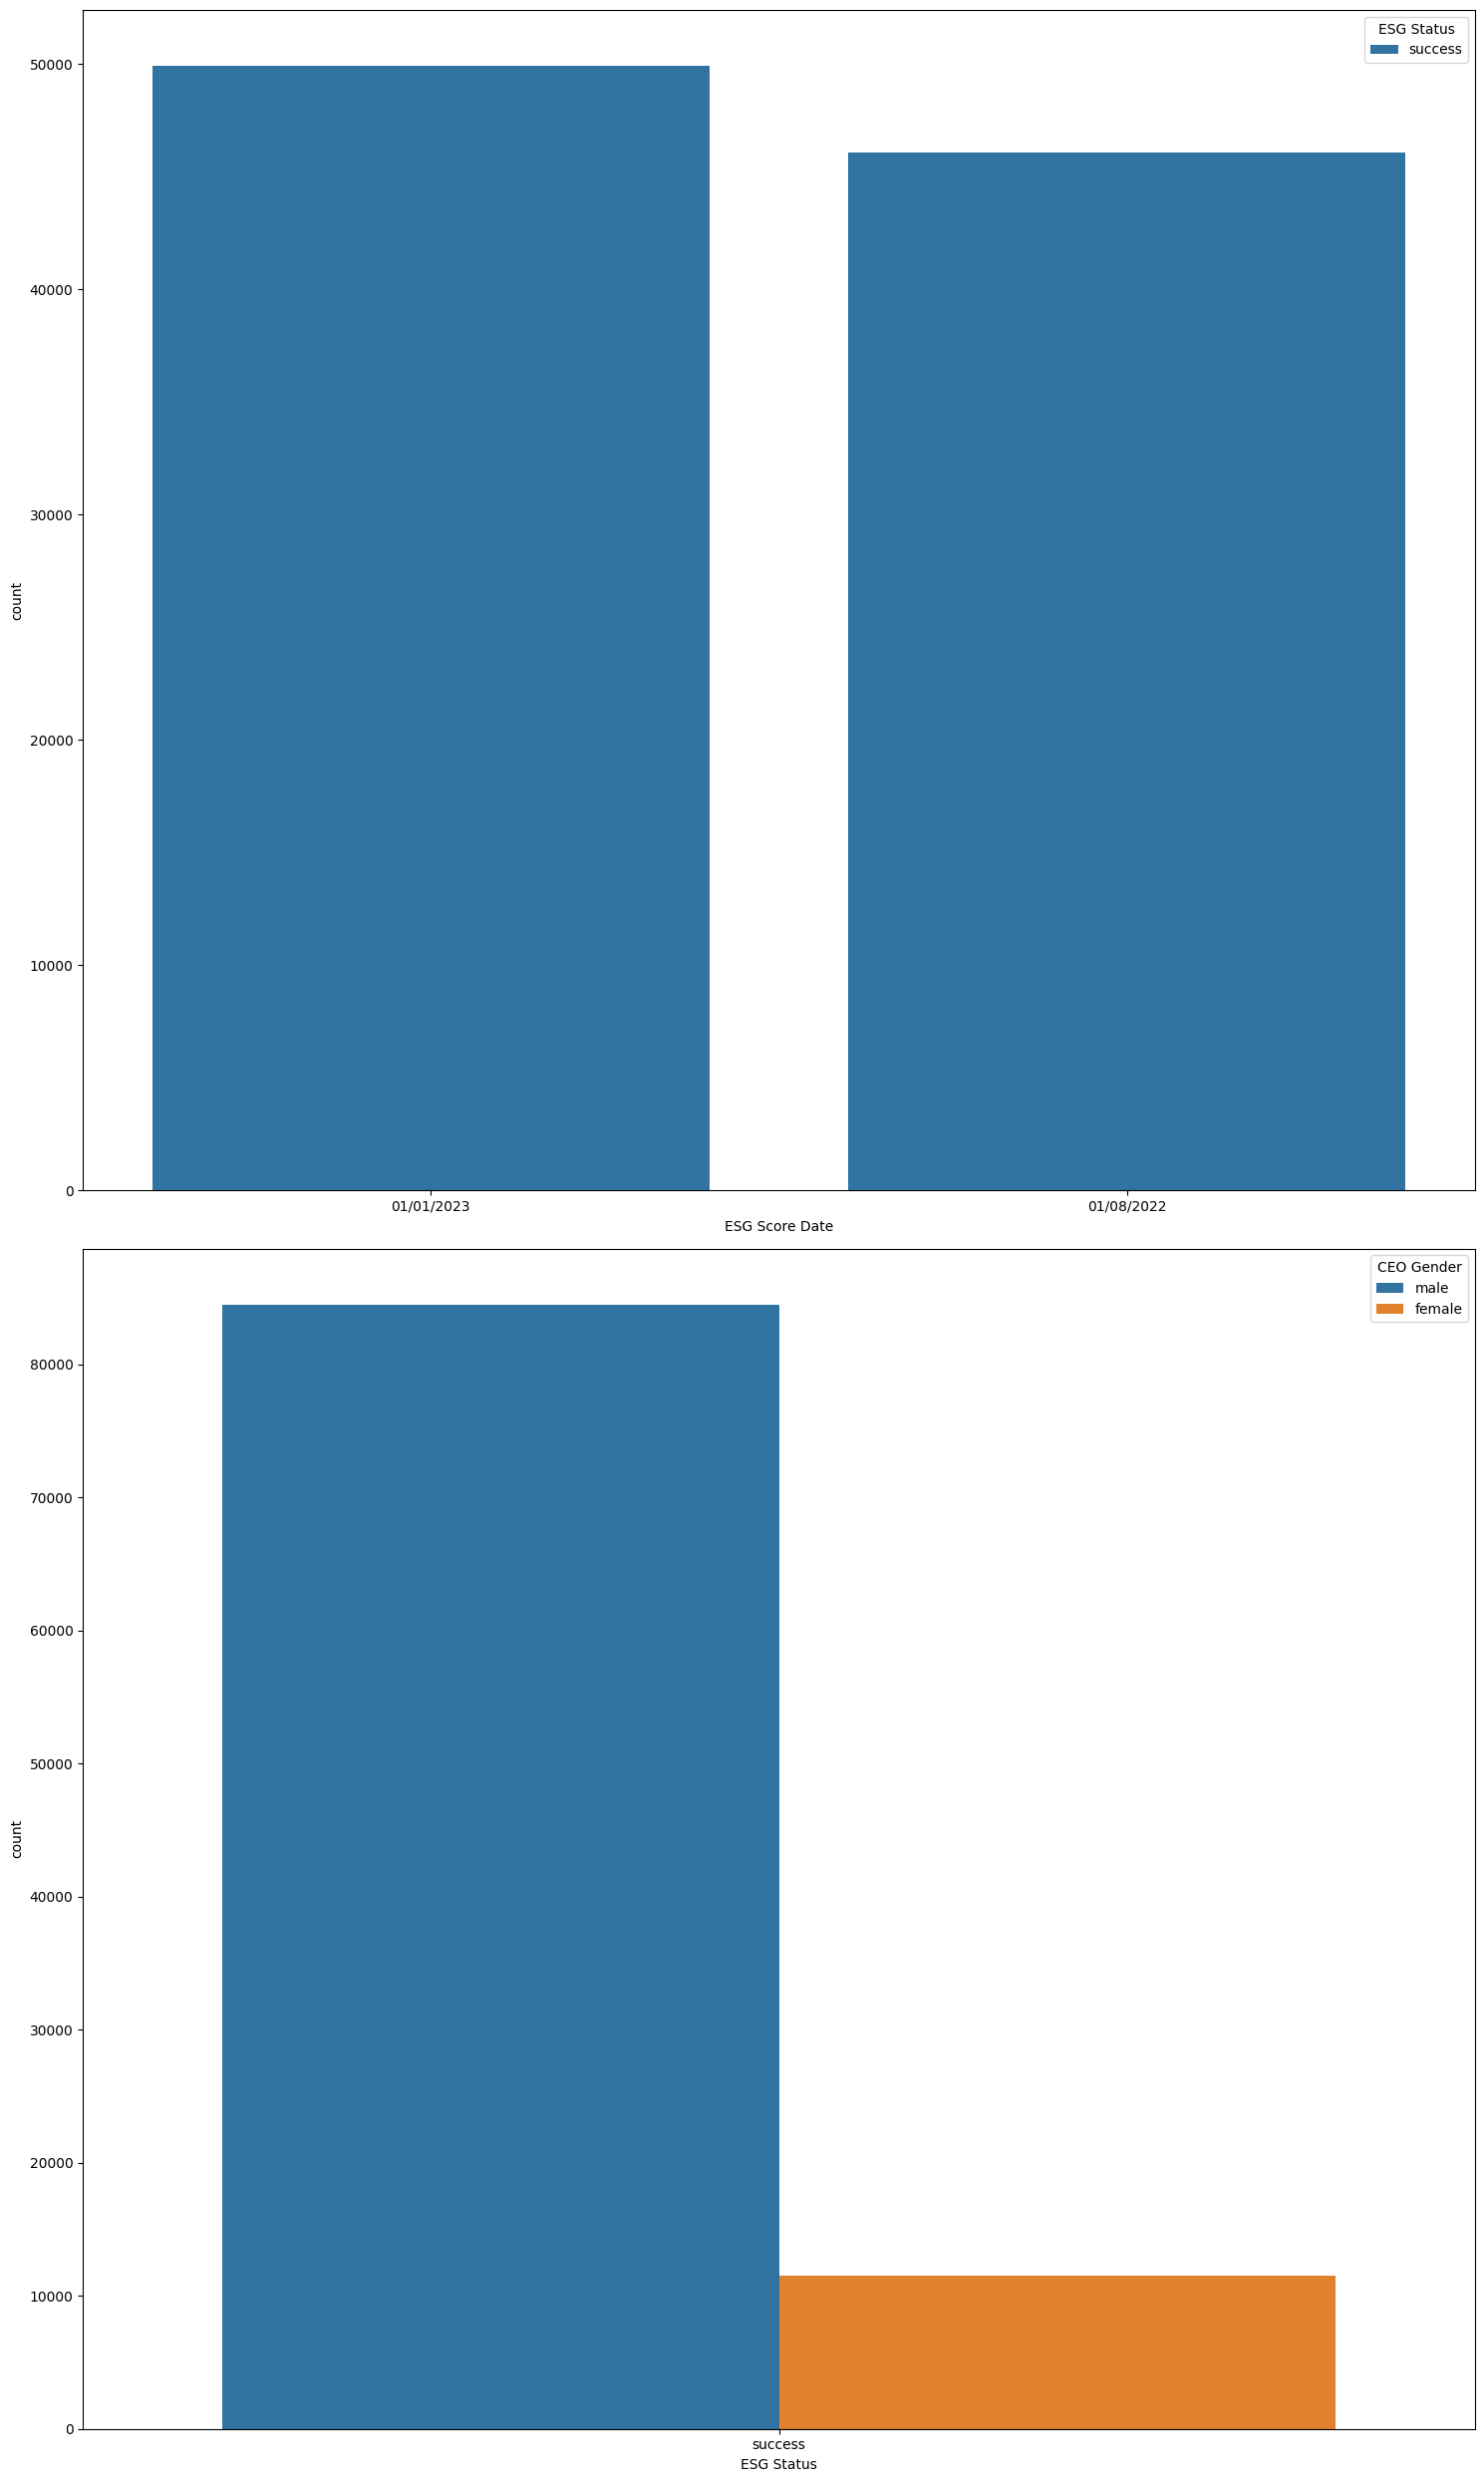

In [25]:
fig, axis = plt.subplots(2, 1, figsize=(15, 25))  

sns.countplot(data=dataset_final, x="ESG Score Date", hue="ESG Status", ax=axis[0])
sns.countplot(data=dataset_final, x="ESG Status", hue="CEO Gender", ax=axis[1])

plt.tight_layout()
plt.show()


## A revisar

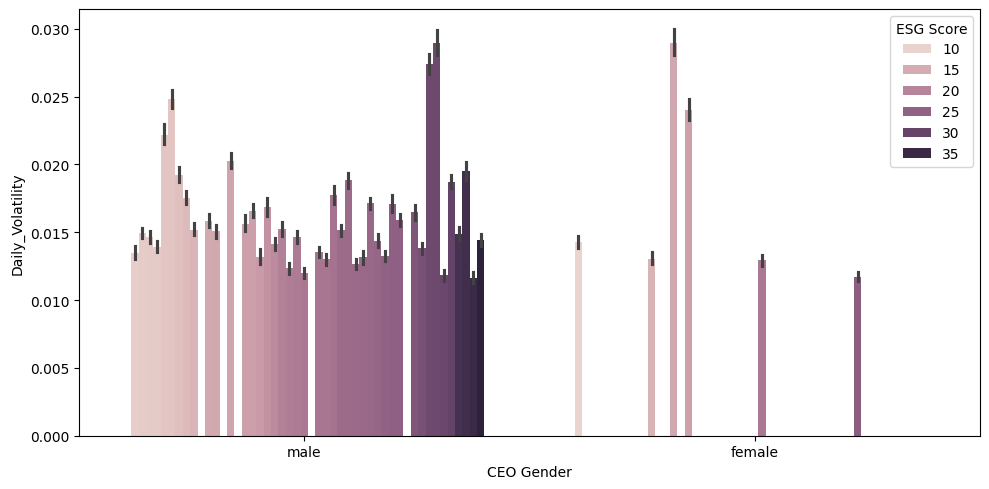

In [26]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 1)

sns.barplot(data = dataset_final, x = "CEO Gender", y = "Daily_Volatility", hue = "ESG Score")

plt.tight_layout()

plt.show()

# ANÁLISIS DE CORRELACIONES

In [27]:
import json 

categorical_f_rules = {}

for col in categorical_variables:
    encoded_col = f"{col}_n"
    dataset_final[encoded_col], uniques = pd.factorize(dataset_final[col])
    dicc = dict(zip(uniques, range(len(uniques))))
    categorical_f_rules[col] = dicc

with open("categorical_rules.json", "w") as f:
    json.dump(categorical_f_rules, f)

with open("categorical_rules.json", "r") as f:
    loaded_mappings = json.load(f)

dataset_final.head()

Date Ticker  Adj Close       Close        High        Low  \
250 2018-01-09      A  67.851906   71.769997   72.330002  70.169998   
251 2018-01-09    AAL  50.760609   52.080002   53.369999  52.009998   
252 2018-01-09   AAPL  40.866245   43.582500   43.764999  43.352501   
253 2018-01-09   ABBV  71.714790  100.239998  100.660004  98.699997   
254 2018-01-09    ABT  51.420975   58.919998   59.099998  58.380001   

          Open      Volume  ESG Score  Governance Score  ...  ESG Score Date  \
250  70.680000   2666100.0      15.24              6.26  ...      01/01/2023   
251  52.970001   3426000.0      29.10              5.26  ...      01/01/2023   
252  43.637501  86336000.0      16.68              9.18  ...      01/08/2022   
253  99.489998   4055400.0      27.84              9.95  ...      01/08/2022   
254  59.099998   7466900.0      24.98              8.36  ...      01/08/2022   

     ESG Status CEO Gender Year Daily_Return  Daily_Volatility  Ticker_n  \
250     success       male   23     0.024553          0.014419         0   
251     success       male   23    -0.000959          0.007580         1   
252     success       male   22    -0.000115          0.005833         2   
253     success       male   22     0.007539          0.014342         3   
254     success       male   22     0.001700          0.002566         4   

     ESG Score Date_n  ESG Status_n  CEO Gender_n  
250                 0             0             0  
251                 0             0             0  
252                 1             0             0  
253                 1             0             0  
254                 1             0             0  

[5 rows x 22 columns]

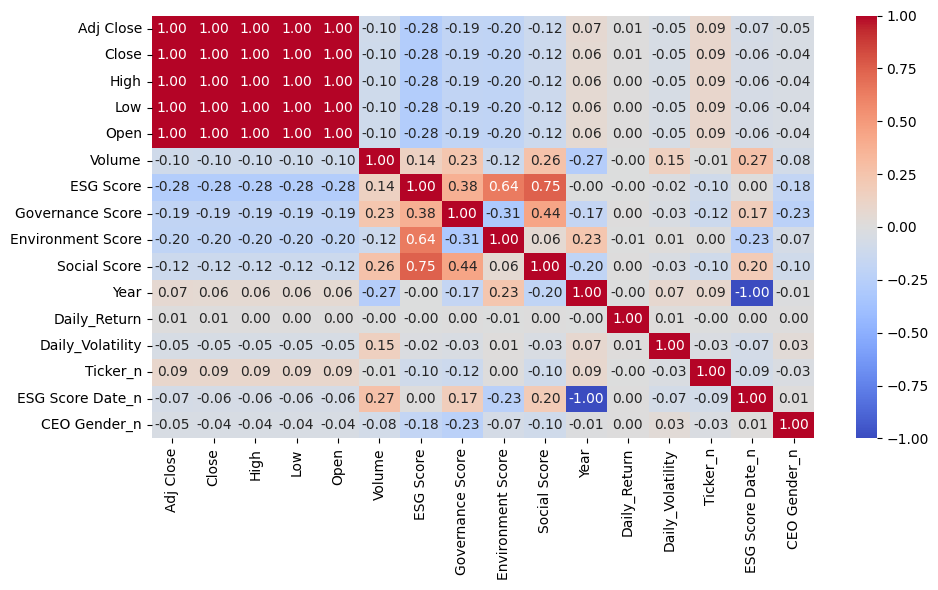

In [28]:
fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    dataset_final[[
        "Adj Close", "Close", "High", "Low", "Open", "Volume",
        "ESG Score", "Governance Score", "Environment Score", "Social Score",
        "Year", "Daily_Return", "Daily_Volatility",
        "Ticker_n", "ESG Score Date_n",
        "CEO Gender_n"
    ]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.tight_layout()
plt.show()


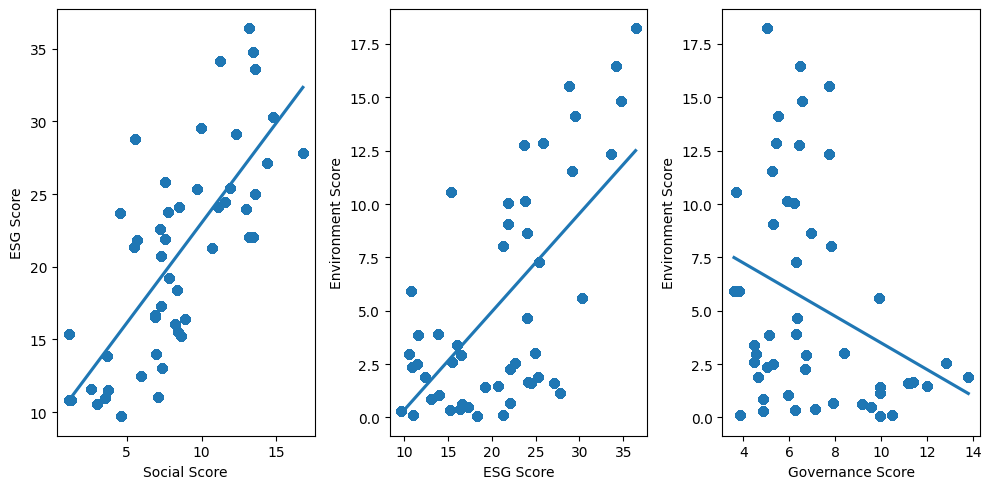

In [29]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 3)
sns.regplot(ax = axis[0], data = dataset_final, x = "Social Score", y = "ESG Score")
sns.regplot(ax = axis[1], data = dataset_final, x = "ESG Score", y = "Environment Score")
sns.regplot(ax = axis[2], data = dataset_final, x = "Governance Score", y = "Environment Score")

plt.tight_layout()
plt.show()

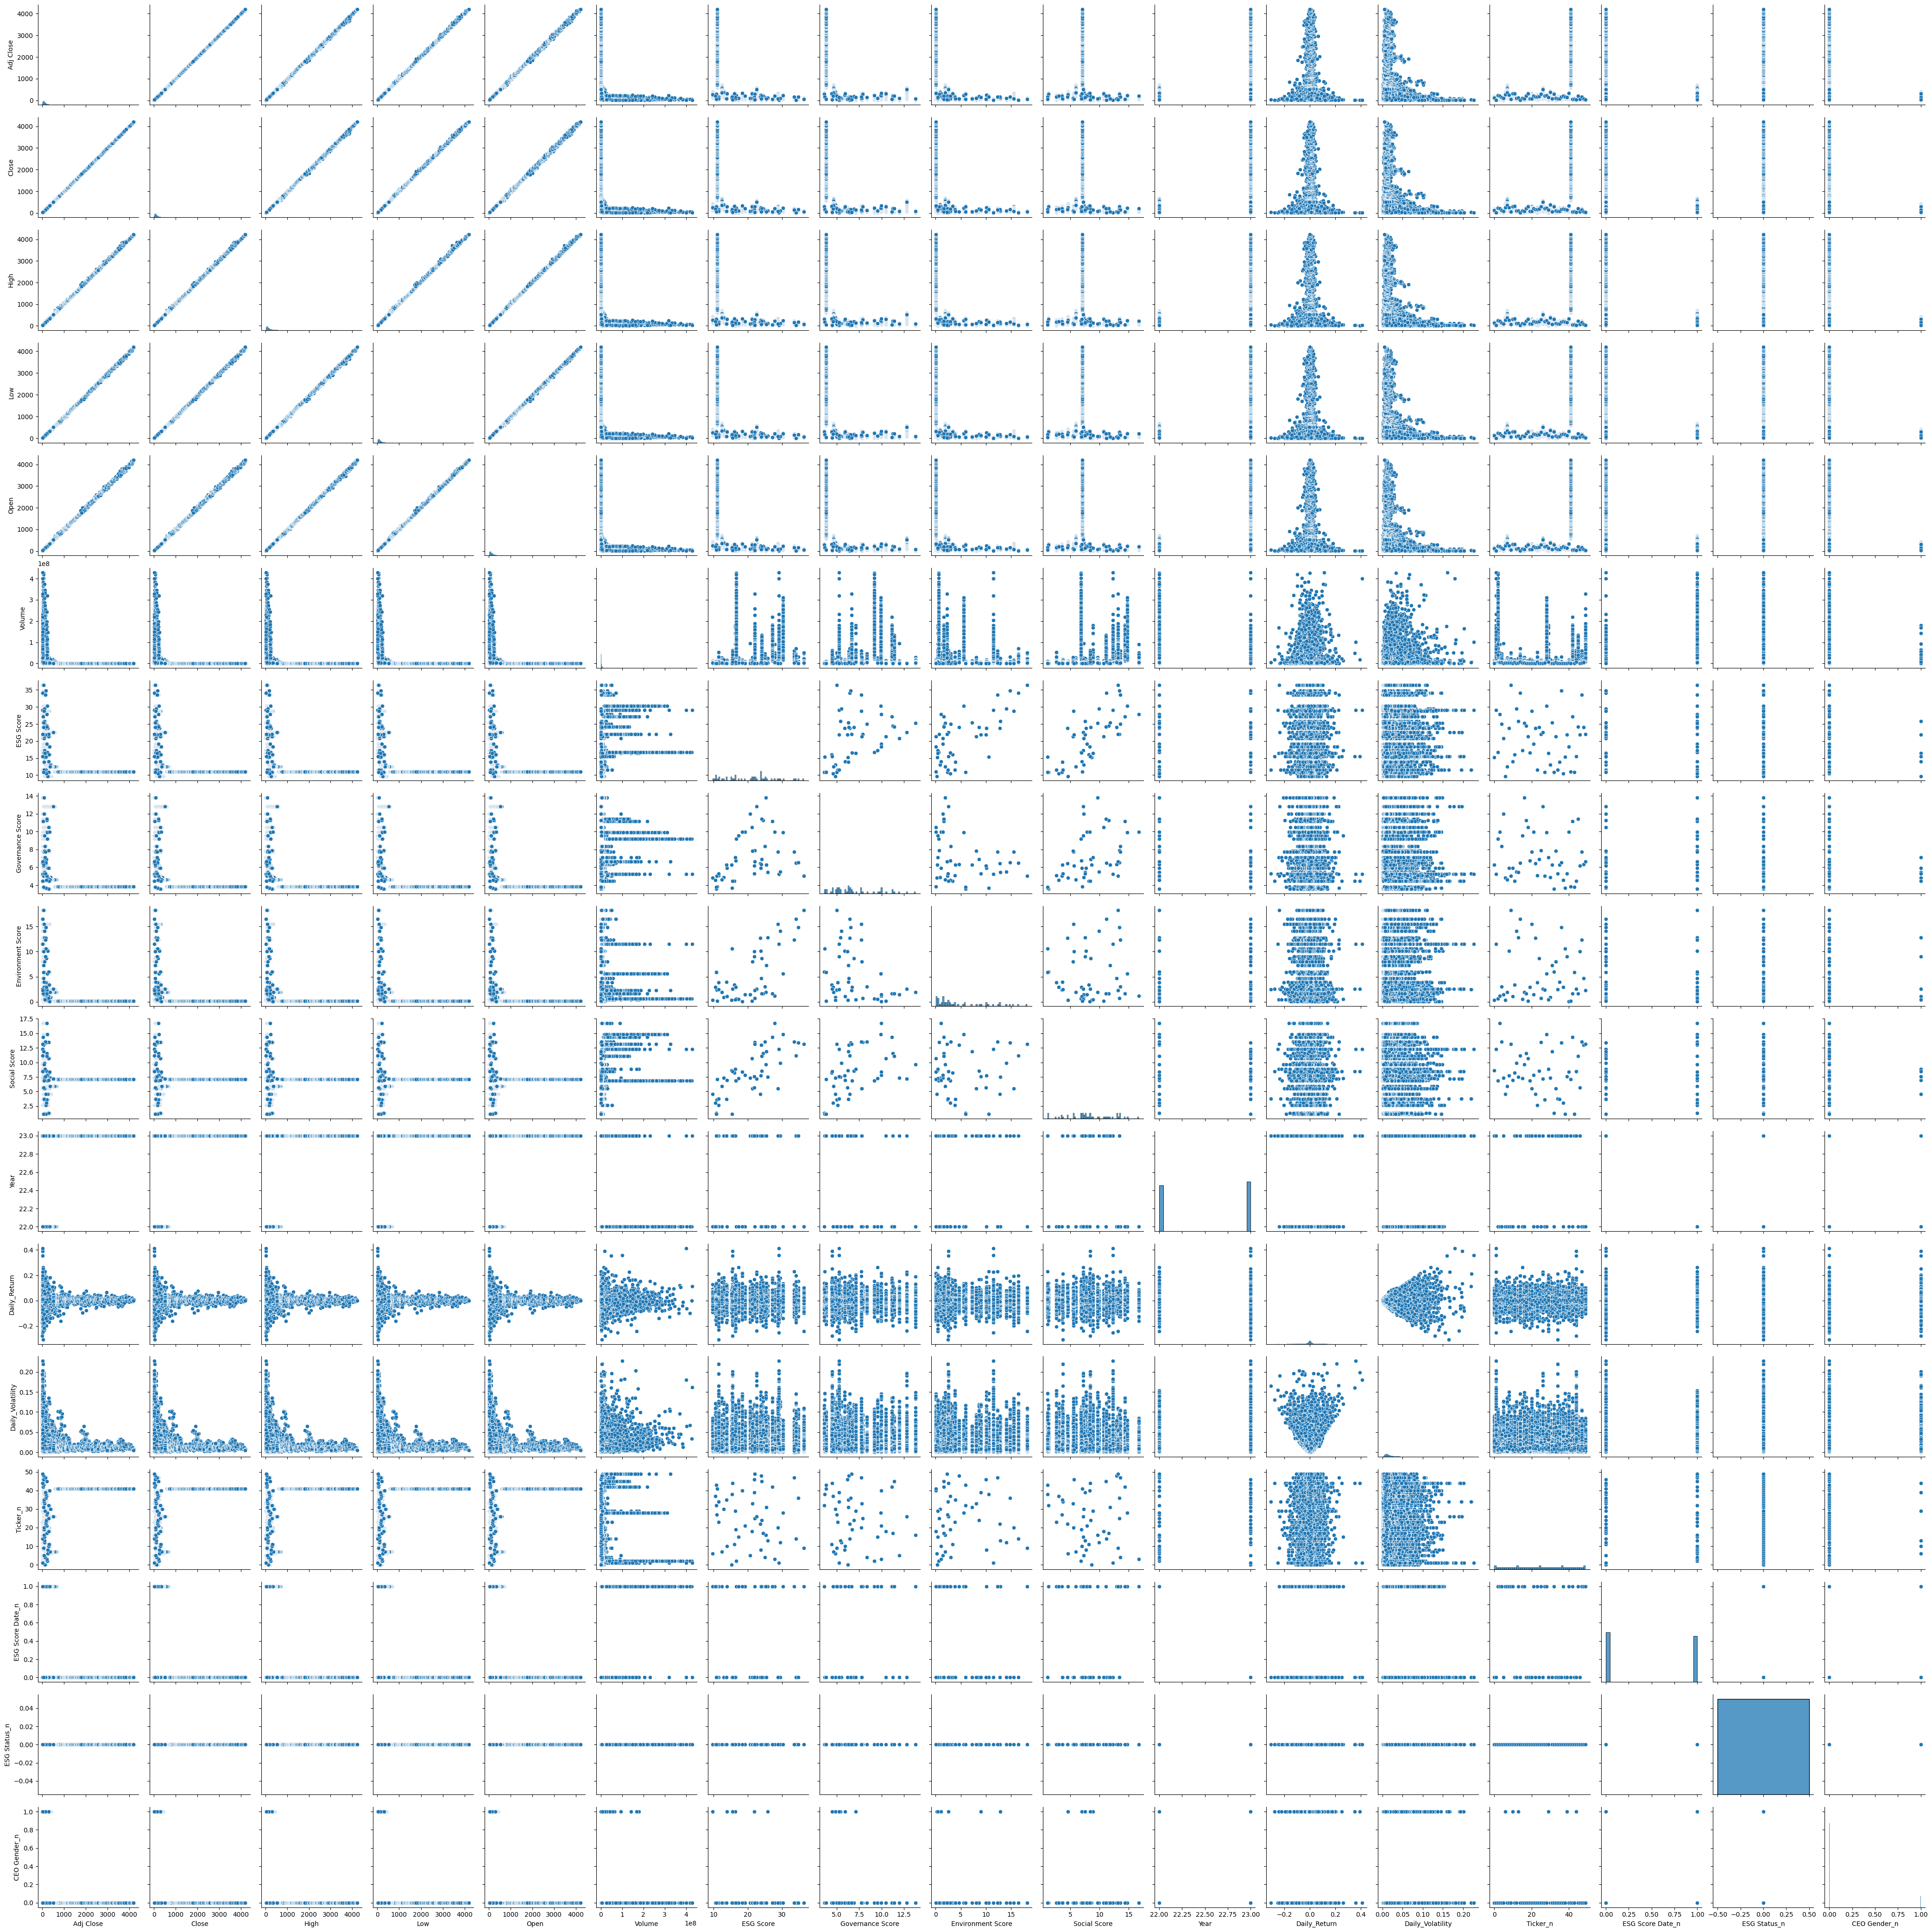

In [30]:
sns.pairplot(data = dataset_final)

In [31]:
dataset_final.describe()

Date     Adj Close         Close  \
count                          96019  96019.000000  96019.000000   
mean   2021-11-01 21:33:47.636197120    154.909818    161.953327   
min              2018-01-09 00:00:00      6.781556      7.413096   
25%              2019-12-05 00:00:00     55.305046     59.709999   
50%              2021-11-01 00:00:00     99.414810    106.410004   
75%              2023-09-29 00:00:00    164.272537    174.020004   
max              2025-08-29 00:00:00   4205.410156   4205.410156   
std                              NaN    296.181541    295.748149   

               High           Low          Open        Volume     ESG Score  \
count  96019.000000  96019.000000  96019.000000  9.601900e+04  96019.000000   
mean     163.670872    160.130323    161.920500  9.231331e+06     20.766090   
min        7.881973      6.467259      7.631366  0.000000e+00      9.710000   
25%       60.380001     59.009998     59.689999  1.050550e+06     15.240000   
50%      107.559998    105.169998    106.430000  2.157400e+06     21.870000   
75%      175.910004    172.217857    174.029999  5.128192e+06     25.320000   
max     4229.680176   4182.259766   4216.020020  4.286171e+08     36.400000   
std      298.528122    292.606546    295.536230  2.243618e+07      7.112774   

       Governance Score  Environment Score  Social Score          Year  \
count      96019.000000       96019.000000  96019.000000  96019.000000   
mean           7.109326           5.293431      8.363337     22.519845   
min            3.590000           0.050000      1.110000     22.000000   
25%            5.100000           1.440000      5.650000     22.000000   
50%            6.430000           2.950000      7.850000     23.000000   
75%            9.180000           9.040000     11.580000     23.000000   
max           13.790000          18.230000     16.770000     23.000000   
std            2.566243           5.121932      3.850643      0.499609   

       Daily_Return  Daily_Volatility      Ticker_n  ESG Score Date_n  \
count  96019.000000      96019.000000  96019.000000      96019.000000   
mean       0.000604          0.016338     24.498224          0.480155   
min       -0.305527          0.000479      0.000000          0.000000   
25%       -0.008404          0.008891     12.000000          0.000000   
50%        0.000917          0.013194     24.000000          0.000000   
75%        0.010018          0.019711     37.000000          1.000000   
max        0.410970          0.226741     49.000000          1.000000   
std        0.020399          0.012576     14.432936          0.499609   

       ESG Status_n  CEO Gender_n  
count       96019.0  96019.000000  
mean            0.0      0.120039  
min             0.0      0.000000  
25%             0.0      0.000000  
50%             0.0      0.000000  
75%             0.0      0.000000  
max             0.0      1.000000  
std             0.0      0.325009

OUTLIERS

In [32]:
dataset_final.describe()

Date     Adj Close         Close  \
count                          96019  96019.000000  96019.000000   
mean   2021-11-01 21:33:47.636197120    154.909818    161.953327   
min              2018-01-09 00:00:00      6.781556      7.413096   
25%              2019-12-05 00:00:00     55.305046     59.709999   
50%              2021-11-01 00:00:00     99.414810    106.410004   
75%              2023-09-29 00:00:00    164.272537    174.020004   
max              2025-08-29 00:00:00   4205.410156   4205.410156   
std                              NaN    296.181541    295.748149   

               High           Low          Open        Volume     ESG Score  \
count  96019.000000  96019.000000  96019.000000  9.601900e+04  96019.000000   
mean     163.670872    160.130323    161.920500  9.231331e+06     20.766090   
min        7.881973      6.467259      7.631366  0.000000e+00      9.710000   
25%       60.380001     59.009998     59.689999  1.050550e+06     15.240000   
50%      107.559998    105.169998    106.430000  2.157400e+06     21.870000   
75%      175.910004    172.217857    174.029999  5.128192e+06     25.320000   
max     4229.680176   4182.259766   4216.020020  4.286171e+08     36.400000   
std      298.528122    292.606546    295.536230  2.243618e+07      7.112774   

       Governance Score  Environment Score  Social Score          Year  \
count      96019.000000       96019.000000  96019.000000  96019.000000   
mean           7.109326           5.293431      8.363337     22.519845   
min            3.590000           0.050000      1.110000     22.000000   
25%            5.100000           1.440000      5.650000     22.000000   
50%            6.430000           2.950000      7.850000     23.000000   
75%            9.180000           9.040000     11.580000     23.000000   
max           13.790000          18.230000     16.770000     23.000000   
std            2.566243           5.121932      3.850643      0.499609   

       Daily_Return  Daily_Volatility      Ticker_n  ESG Score Date_n  \
count  96019.000000      96019.000000  96019.000000      96019.000000   
mean       0.000604          0.016338     24.498224          0.480155   
min       -0.305527          0.000479      0.000000          0.000000   
25%       -0.008404          0.008891     12.000000          0.000000   
50%        0.000917          0.013194     24.000000          0.000000   
75%        0.010018          0.019711     37.000000          1.000000   
max        0.410970          0.226741     49.000000          1.000000   
std        0.020399          0.012576     14.432936          0.499609   

       ESG Status_n  CEO Gender_n  
count       96019.0  96019.000000  
mean            0.0      0.120039  
min             0.0      0.000000  
25%             0.0      0.000000  
50%             0.0      0.000000  
75%             0.0      0.000000  
max             0.0      1.000000  
std             0.0      0.325009

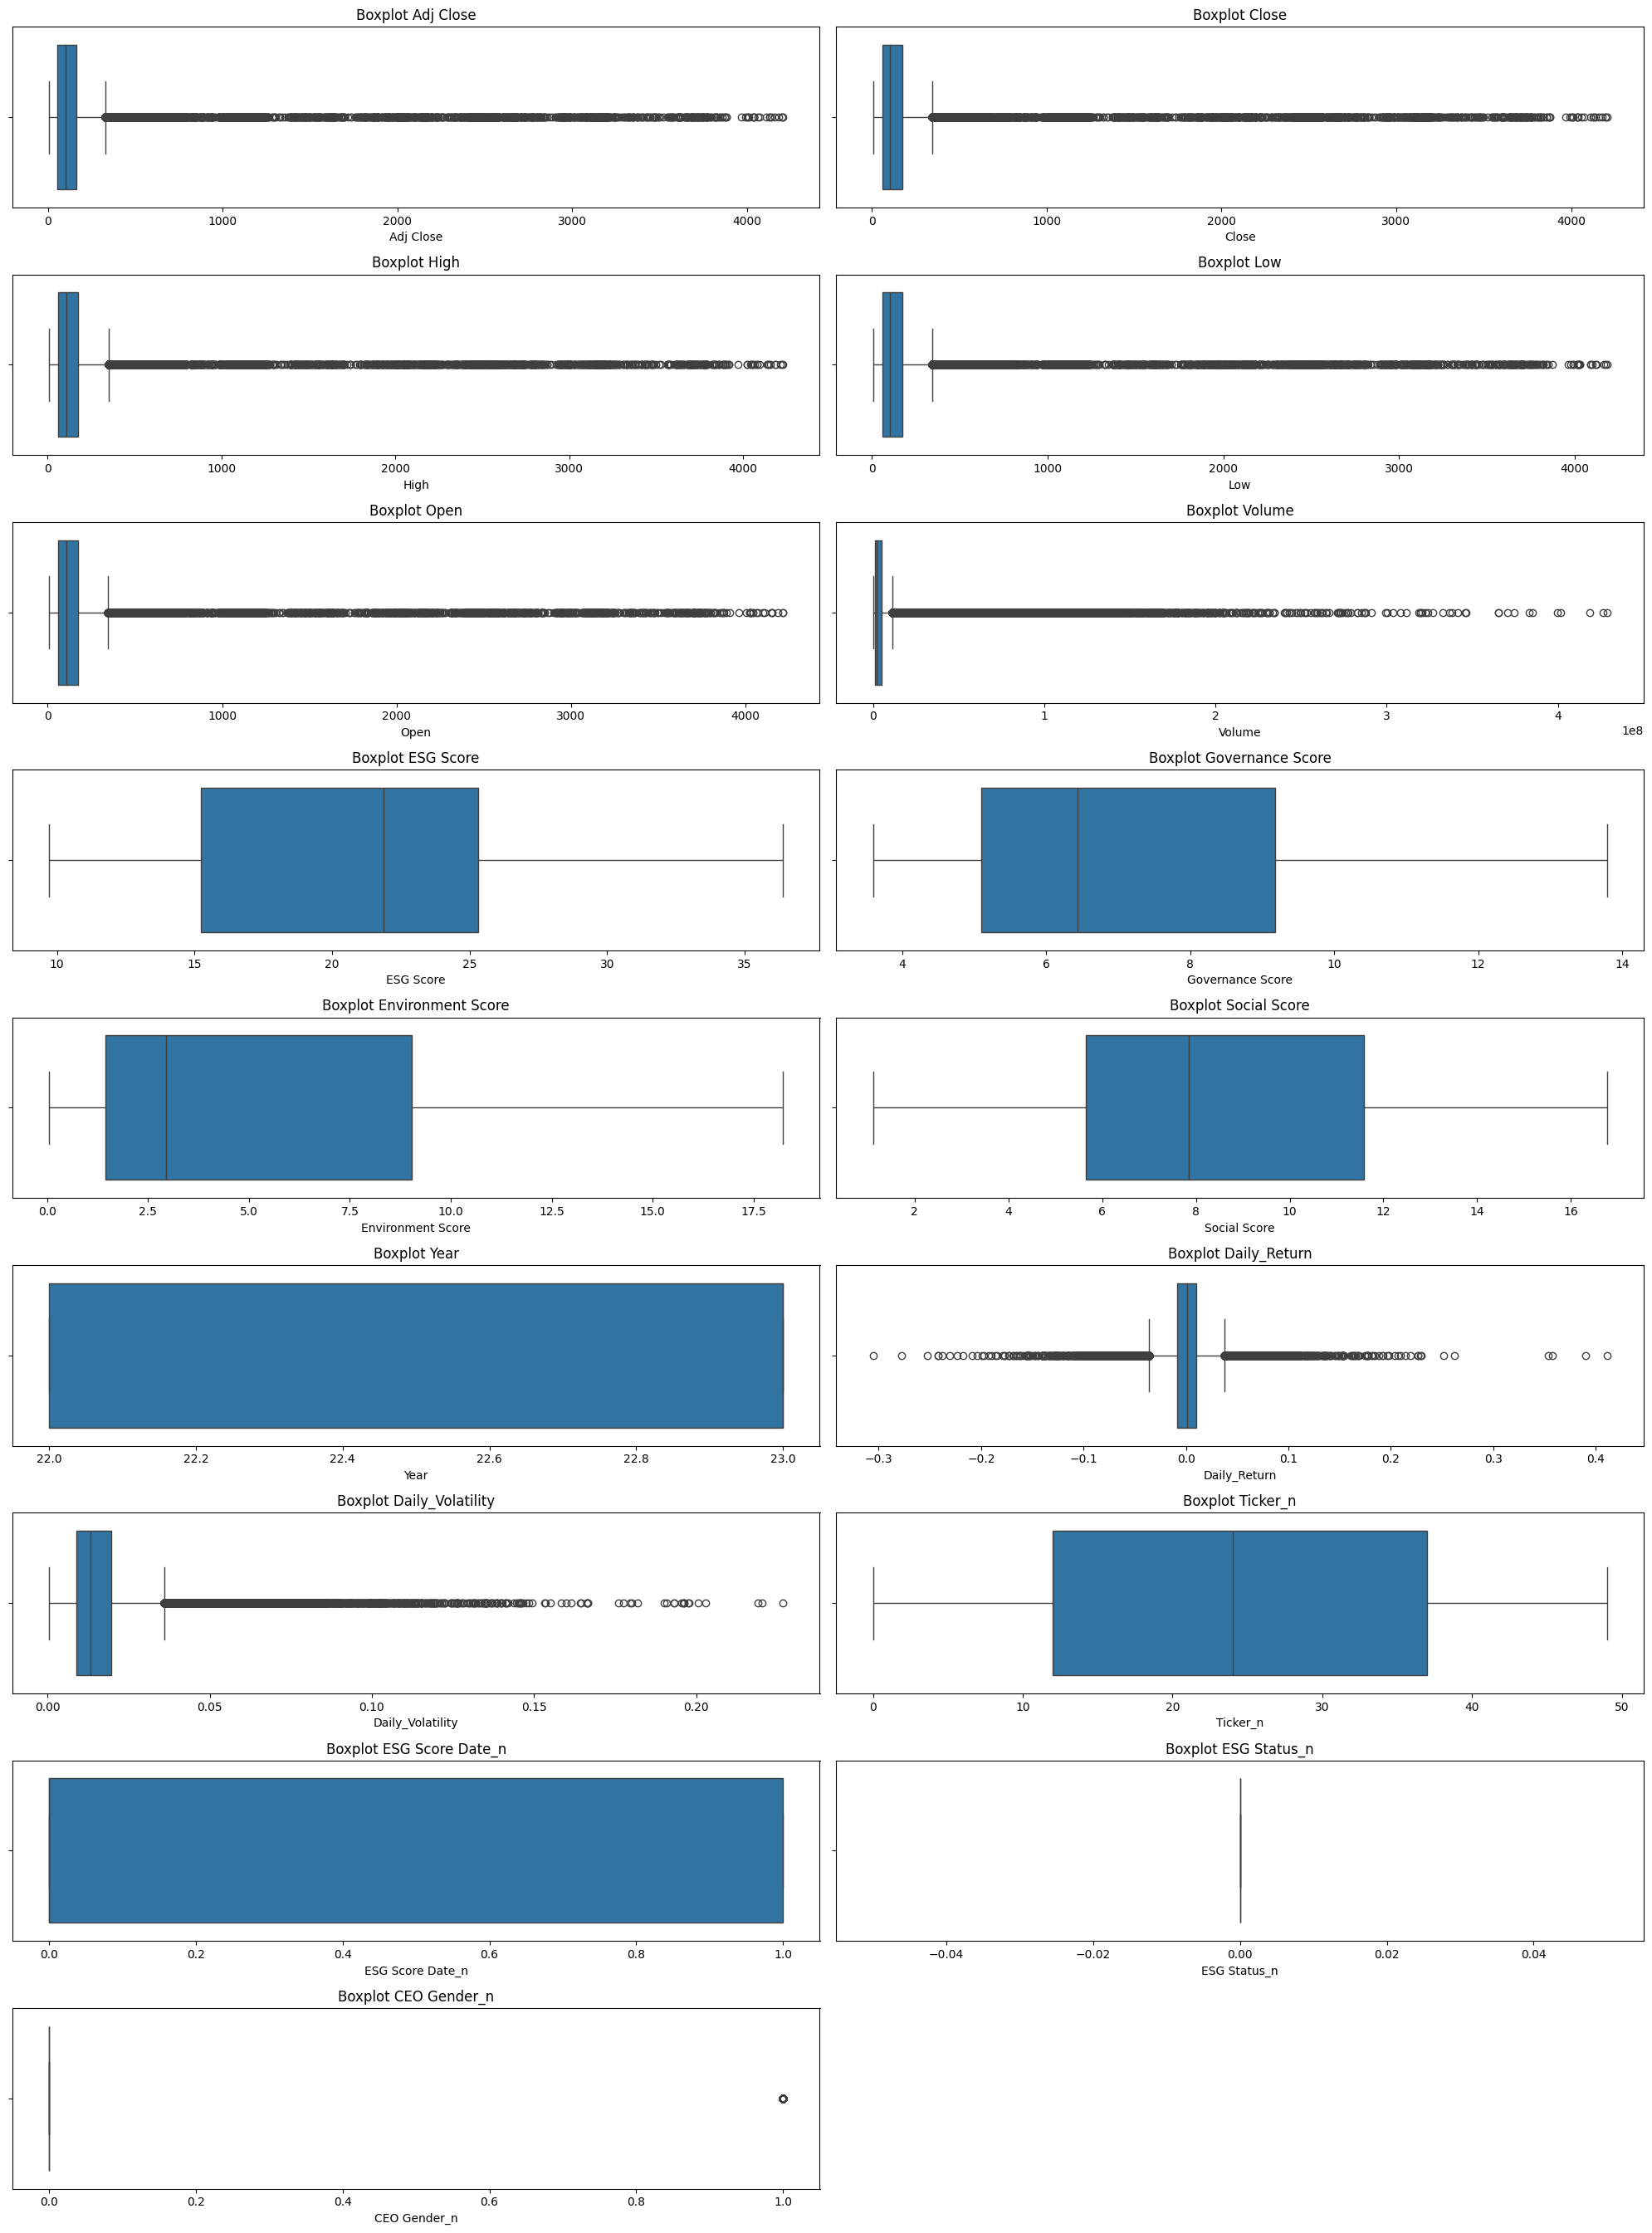

In [33]:
numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)# Definir grid
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, nrows * 3)
)

axes = axes.flatten()# Solo boxplots
for i, var in enumerate(numerical_variables):
    sns.boxplot(data=dataset_final, x=var, ax=axes[i])
    axes[i].set_title(f"Boxplot {var}") # Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Eliminar factorizados

In [34]:
numerical_columns = [
   'Adj Close', 
   'Close', 
   'High', 
   'Low', 
   'Open', 
   'Volume', 
   'ESG Score',
   'Governance Score', 
   'Environment Score', 
   'Social Score', 
   'Year',
   'Daily_Return'
]

for column in numerical_columns:
    stats = dataset_final[column].describe()
    iqr = stats["75%"] - stats["25%"]
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr
    if lower_limit < 0:
      lower_limit = 0
    
    outliers = dataset_final[(dataset_final[column] < lower_limit) | (dataset_final[column] > upper_limit)]
    outlier_count = outliers.shape[0]

    print(f"{column.capitalize()} — IQR: {round(iqr, 2)}, Upper limits: {round(upper_limit, 2)}, Lowerlimits: {round(lower_limit, 2)}")
    print(f"Total de outliers: {outlier_count}\n")

Adj close — IQR: 108.97, Upper limits: 327.72, Lowerlimits: 0
Total de outliers: 4709

Close — IQR: 114.31, Upper limits: 345.49, Lowerlimits: 0
Total de outliers: 4174

High — IQR: 115.53, Upper limits: 349.21, Lowerlimits: 0
Total de outliers: 4192

Low — IQR: 113.21, Upper limits: 342.03, Lowerlimits: 0
Total de outliers: 4183

Open — IQR: 114.34, Upper limits: 345.54, Lowerlimits: 0
Total de outliers: 4172

Volume — IQR: 4077642.0, Upper limits: 11244655.0, Lowerlimits: 0
Total de outliers: 13287

Esg score — IQR: 10.08, Upper limits: 40.44, Lowerlimits: 0.12
Total de outliers: 0

Governance score — IQR: 4.08, Upper limits: 15.3, Lowerlimits: 0
Total de outliers: 0

Environment score — IQR: 7.6, Upper limits: 20.44, Lowerlimits: 0
Total de outliers: 0

Social score — IQR: 5.93, Upper limits: 20.48, Lowerlimits: 0
Total de outliers: 0

Year — IQR: 1.0, Upper limits: 24.5, Lowerlimits: 20.5
Total de outliers: 0

Daily_return — IQR: 0.02, Upper limits: 0.04, Lowerlimits: 0
Total de ou

In [35]:
dataset_final.isnull().sum().sort_values(ascending=False) / len(dataset_final)

Date                 0.0
Ticker               0.0
Adj Close            0.0
Close                0.0
High                 0.0
Low                  0.0
Open                 0.0
Volume               0.0
ESG Score            0.0
Governance Score     0.0
Environment Score    0.0
Social Score         0.0
ESG Score Date       0.0
ESG Status           0.0
CEO Gender           0.0
Year                 0.0
Daily_Return         0.0
Daily_Volatility     0.0
Ticker_n             0.0
ESG Score Date_n     0.0
ESG Status_n         0.0
CEO Gender_n         0.0
dtype: float64

# SPLIT TRAIN/TEST #

In [36]:
from sklearn.model_selection import train_test_split


num_variables = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score','Governance Score', 'Environment Score', 'Social Score', 'Year', 'Daily_Return', 'Ticker_n', 'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n']

X = dataset_final.drop("Daily_Volatility", axis = 1)[num_variables]
y = dataset_final["Daily_Volatility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

Adj Close        Close         High          Low         Open  \
95488   198.050003   198.050003   200.330002   197.139999   199.080002   
70902   175.510864   177.229996   177.679993   176.250000   177.059998   
57991  2223.270020  2223.270020  2250.350098  2208.820068  2249.100098   
91990   264.282776   264.950012   268.000000   262.529999   264.940002   
30923    57.210938    60.000000    60.430000    58.540001    58.730000   

           Volume  ESG Score  Governance Score  Environment Score  \
95488   4101700.0      27.84              9.95               1.12   
70902  42038900.0      16.68              9.18               0.65   
57991    143000.0      11.04              3.83               0.11   
91990   1561500.0      18.38              9.95               0.05   
30923   8338100.0      11.56              5.10               3.84   

       Social Score  Year  Daily_Return  Ticker_n  ESG Score Date_n  \
95488         16.77    22     -0.004073         3                 1   
70902          6.86    22      0.007905         2                 1   
57991          7.09    23      0.000342        41                 0   
91990          8.37    22      0.000529        40                 1   
30923          2.62    22      0.024940        23                 1   

       ESG Status_n  CEO Gender_n  
95488             0             0  
70902             0             0  
57991             0             0  
91990             0             0  
30923             0             0